In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sms-spam-collection-dataset/spam.csv


<h3>In this notebook we would be conducting EDA, selecting classifier model and saving the model for deployment</h3>

In [2]:
#importing required libraries

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.ensemble import VotingClassifier
tfidf = TfidfVectorizer(max_features=3000)
cv = CountVectorizer()

import nltk
import string
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter

string.punctuation
ps = PorterStemmer()


In [3]:
df=pd.read_csv("../input/sms-spam-collection-dataset/spam.csv",encoding =  'ISO-8859-1')
df.head(3)

#ISO 8859-1 is a single-byte encoding that can represent the first 256 Unicode characters

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN


In [4]:
print('shape of the data is, ', df.shape,'\n\n', 'Number of duplicate data is, ', df.duplicated().sum())


shape of the data is,  (5572, 5) 

 Number of duplicate data is,  403


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [6]:
#let's check validity of each given column 

#since all the last three columns almost no data we would drop them

df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'], inplace=True)

In [7]:
df.sample(5)

,v1,v2
4715,ham,Hey. What happened? U switch off ur cell d who...
357,spam,Ur cash-balance is currently 500 pounds - to m...
2969,ham,U should make a fb list
3406,ham,Beautiful Truth against Gravity.. Read careful...
3077,ham,Okay but i thought you were the expert


In [8]:
#lets rename our columns with correct attribute name
df.rename(columns={'v1': 'target', 'v2': 'sms'},inplace = True)

In [9]:
encoder = LabelEncoder()
df['target'] = encoder.fit_transform(df['target'])

In [10]:
#lets remove duplicate data availabale
df= df.drop_duplicates(keep = 'first')

In [11]:
#after cleaning the data
print('shape of the data is, ', df.shape,'\n\n','Number of duplicate data is, ', df.duplicated().sum())

print('total sum of null values\n')
df.isnull().sum()

shape of the data is,  (5169, 2) 

 Number of duplicate data is,  0
total sum of null values



target    0
sms       0
dtype: int64

<h3>EDA on the Data</h3>

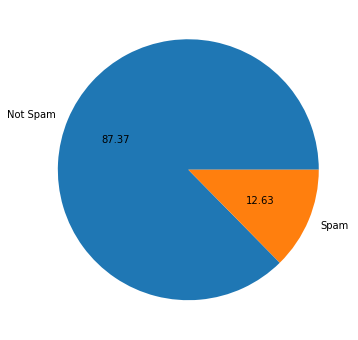

In [12]:
#let's see the count of data in the target column in a pie chart
plt.figure(figsize=(12,6))
plt.pie(df['target'].value_counts(), labels=['Not Spam', "Spam"], autopct ='%0.2f')
plt.show() 

We could notice here that the target coulmn is imbalanced

In [13]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

adding Columns to learn more about the text len and structure

In [14]:
#inserting column with the len of each respective text msg - number of characters present
df['character_len']= df['sms'].apply(len)
df.head(3)

,target,sms,character_len
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155


In [15]:
#getting the number of words in each sms into a new column
df['word_len'] = df['sms'].apply(lambda x:len(nltk.word_tokenize(x)))
df.head(3)

,target,sms,character_len,word_len
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37


In [16]:
#getting the number of sentences in each sms into a new column
df['sent_len'] = df['sms'].apply(lambda x:len(nltk.sent_tokenize(x)))
df.head(3)

,target,sms,character_len,word_len,sent_len
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2


In [17]:
df.describe()

,target,character_len,word_len,sent_len
count,5169.000000,5169.000000,5169.000000,5169.000000
mean,0.126330,78.977945,18.453279,1.947185
std,0.332253,58.236293,13.324793,1.362406
min,0.000000,2.000000,1.000000,1.000000
25%,0.000000,36.000000,9.000000,1.000000
50%,0.000000,60.000000,15.000000,1.000000
75%,0.000000,117.000000,26.000000,2.000000
max,1.000000,910.000000,220.000000,28.000000


the ABOVE table describes the average characters, words and sentences used in general in a sms according to our data

In [18]:
df[df['target'] == 0 ][['word_len','sent_len', 'character_len']].describe()

#description of data for messages that are not spam


,word_len,sent_len,character_len
count,4516.000000,4516.000000,4516.000000
mean,17.120903,1.799601,70.459256
std,13.493725,1.278465,56.358207
min,1.000000,1.000000,2.000000
25%,8.000000,1.000000,34.000000
50%,13.000000,1.000000,52.000000
75%,22.000000,2.000000,90.000000
max,220.000000,28.000000,910.000000


In [19]:
df[df['target'] == 1 ][['word_len','sent_len', 'character_len']].describe()

#description of data for messages that are spam


,word_len,sent_len,character_len
count,653.000000,653.000000,653.000000
mean,27.667688,2.967841,137.891271
std,7.008418,1.483201,30.137753
min,2.000000,1.000000,13.000000
25%,25.000000,2.000000,132.000000
50%,29.000000,3.000000,149.000000
75%,32.000000,4.000000,157.000000
max,46.000000,8.000000,224.000000


the below graph represents word_len vs count for spam and not spam messages, lets represnt this using a histogram

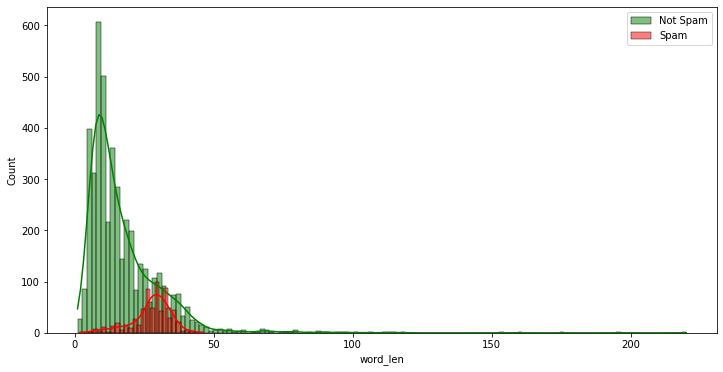

In [20]:
plt.figure(figsize=(12,6))
sns.histplot(data= df[df['target']==0], x="word_len", color="green", label="Not Spam", kde=True)
sns.histplot(data= df[df['target']==1], x="word_len", color="red", label="Spam", kde=True)
plt.legend() 
plt.show()

the below graph represents word_len vs count for spam and not spam messages

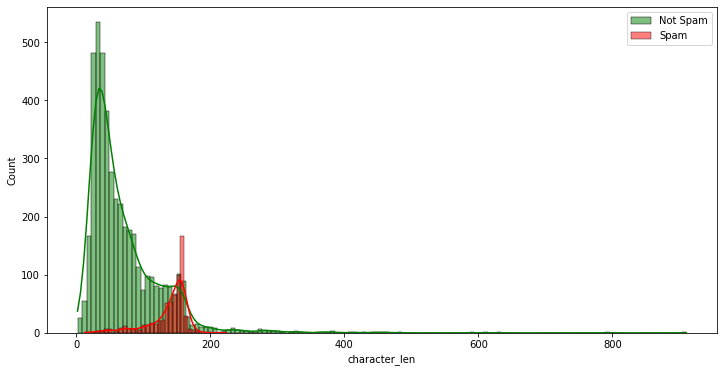

In [21]:
plt.figure(figsize=(12,6))
sns.histplot(data= df[df['target']==0], x="character_len", color="green", label="Not Spam", kde=True)
sns.histplot(data= df[df['target']==1], x="character_len", color="red", label="Spam", kde=True)
plt.legend() 
plt.show()

the above graph represents character_len vs count for spam and not spam messages

<Figure size 864x432 with 0 Axes>

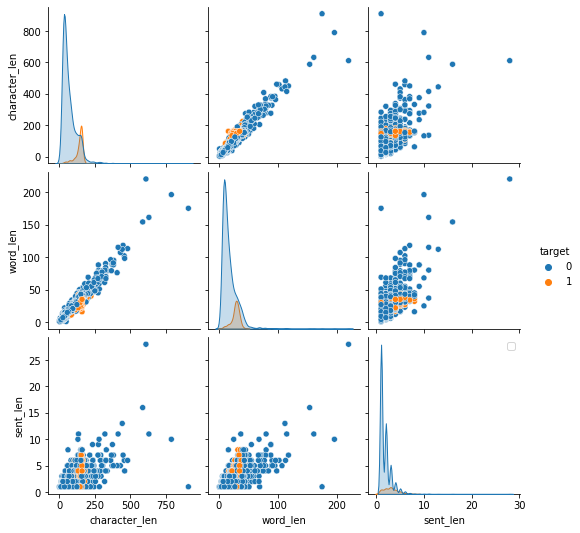

In [22]:
plt.figure(figsize=(12,6))
sns.pairplot(df, hue ='target')
plt.legend() 
plt.show()

here 0 is not spam and 1 is for spam, we conclude the data consists of outliers from the above graphs. The linear relation between characetr, words and sentences is also established

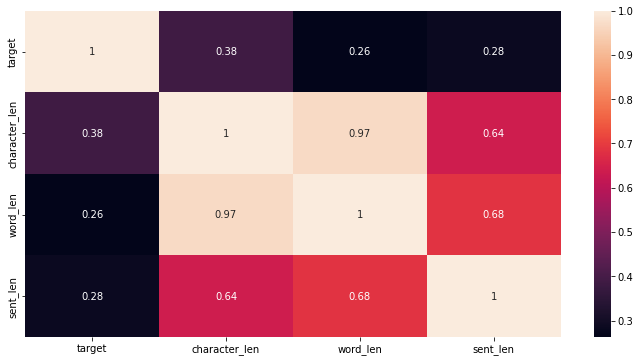

In [23]:
plt.figure(figsize=(12,6))
sns.heatmap(data=df.corr(),annot= True)
plt.show()

Due to high collinearity of all three columns, we should keep only one column for our model. We would go with character_len beacuse it has comparitively high correlation with the target column

text preprocessing

lower case --> tokenization --> removing special characters --> removing stop words and punctuations --> stemming 

In [24]:
#let's create a function were all steps of data processing would take place altogether

def text_transform(text):
    text = text.lower()
    text = nltk.word_tokenize(text) #seprating each word
    
    l = []
    for i in text:
        if i.isalnum():
            l.append(i) #considering only alphabets and numbers
    
    text = l[:]
    l.clear()
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            l.append(i)
            
    text = l[:]
    l.clear()        
    for i in text:
        l.append(ps.stem(i)) #applied stemming i.e. reduncing word to its root form
    
    return " ".join(l)

#example of function text_transform
text_transform('I love YT lectures on Machine Learning. How about You and others?')

'love yt lectur machin learn other'

In [25]:
#applying transformation to all text messages
df['transformed_text']= df['sms'].apply(text_transform)
df.head(5)

,target,sms,character_len,word_len,sent_len,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [26]:
spam_corpus =[]
for msg in df[df['target']==1]['transformed_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


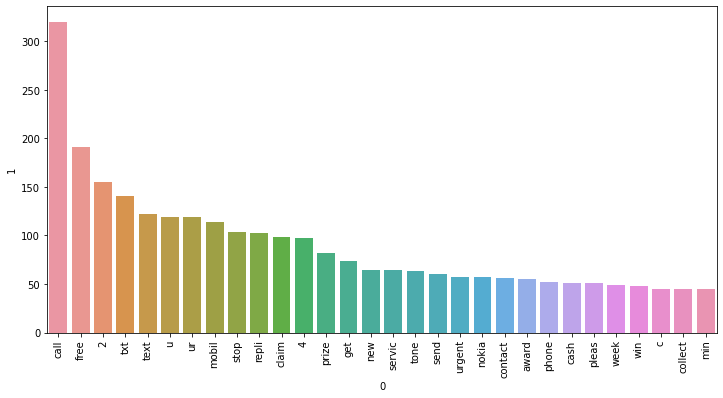

In [27]:
#this will get us the most common words in spam messages
plt.figure(figsize=(12,6))
sns.barplot(pd.DataFrame(Counter(spam_corpus).most_common(30))[0],pd.DataFrame(Counter(spam_corpus).most_common(30))[1])
plt.xticks(rotation = 'vertical')
plt.show()

This is the graph representing highest 30 used words in spam messages


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


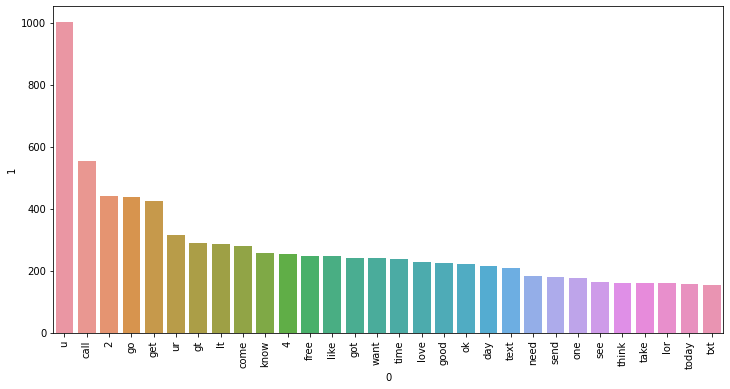

In [28]:
ham_corpus =[]
for msg in df[df['target']== 0]['transformed_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)
plt.figure(figsize=(12,6))
sns.barplot(pd.DataFrame(Counter(spam_corpus).most_common(30))[0],pd.DataFrame(Counter(spam_corpus).most_common(30))[1])
plt.xticks(rotation = 'vertical')
plt.show()

This is the graph representing highest 30 used words in normal messages

Model Building

In [29]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

performance matrices

* Accuracy is a metric used in classification problems used to tell the percentage of accurate predictions

* Confusion Matrix: It is a matrix of size 2×2 for binary classification with actual values on one axis and predicted on another.
![](https://miro.medium.com/max/872/1*UsOWxGhFMhkfkFZivPFlpQ.png)

* The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative. The best value is 1 and the worst value is 0.

In [30]:
# first with Countvectorizer
X = cv.fit_transform(df['transformed_text']).toarray()
y = df['target'].values
print("Shape of X", X.shape, '& Shape of y', y.shape, '\n\n')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

print('Performace Metrices for GaussianNB')
gnb.fit(X_train,y_train)
y_pred_gnb = gnb.predict(X_test)
print('Accuracy  is :',accuracy_score(y_test, y_pred_gnb))
print('Confusion Matrix :\n',confusion_matrix(y_test, y_pred_gnb))
print('Precision score is :',precision_score(y_test, y_pred_gnb))
print('\n\n')

print('Performace Metrices for MultinomialNB')
mnb.fit(X_train,y_train)
y_pred_mnb = mnb.predict(X_test)
print('Accuracy  is :',accuracy_score(y_test, y_pred_mnb))
print('Confusion Matrix :\n',confusion_matrix(y_test, y_pred_mnb))
print('Precision score is :',precision_score(y_test, y_pred_mnb))
print('\n\n')

print('Performace Metrices for BernoulliNB')
bnb.fit(X_train,y_train)
y_pred_bnb = bnb.predict(X_test)
print('Accuracy  is :',accuracy_score(y_test, y_pred_bnb))
print('Confusion Matrix :\n',confusion_matrix(y_test, y_pred_bnb))
print('Precision score is :',precision_score(y_test, y_pred_bnb))
print('\n\n')

Shape of X (5169, 6708) & Shape of y (5169,) 


Performace Metrices for GaussianNB
Accuracy  is : 0.8800773694390716
Confusion Matrix :
 [[792 104]
 [ 20 118]]
Precision score is : 0.5315315315315315



Performace Metrices for MultinomialNB
Accuracy  is : 0.9642166344294004
Confusion Matrix :
 [[871  25]
 [ 12 126]]
Precision score is : 0.8344370860927153



Performace Metrices for BernoulliNB
Accuracy  is : 0.9700193423597679
Confusion Matrix :
 [[893   3]
 [ 28 110]]
Precision score is : 0.9734513274336283





In [31]:
# with TfidfVectorizer
X = tfidf.fit_transform(df['transformed_text']).toarray()
y = df['target'].values
print("Shape of X", X.shape, '& Shape of y', y.shape, '\n\n')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

print('Performace Metrices for GaussianNB')
gnb.fit(X_train,y_train)
y_pred_gnb = gnb.predict(X_test)
print('Accuracy  is :',accuracy_score(y_test, y_pred_gnb))
print('Confusion Matrix :\n',confusion_matrix(y_test, y_pred_gnb))
print('Precision score is :',precision_score(y_test, y_pred_gnb))
print('\n\n')

print('Performace Metrices for MultinomialNB')
mnb.fit(X_train,y_train)
y_pred_mnb = mnb.predict(X_test)
print('Accuracy  is :',accuracy_score(y_test, y_pred_mnb))
print('Confusion Matrix :\n',confusion_matrix(y_test, y_pred_mnb))
print('Precision score is :',precision_score(y_test, y_pred_mnb))
print('\n\n')

print('Performace Metrices for BernoulliNB')
bnb.fit(X_train,y_train)
y_pred_bnb = bnb.predict(X_test)
print('Accuracy  is :',accuracy_score(y_test, y_pred_bnb))
print('Confusion Matrix :\n',confusion_matrix(y_test, y_pred_bnb))
print('Precision score is :',precision_score(y_test, y_pred_bnb))
print('\n\n')

Shape of X (5169, 3000) & Shape of y (5169,) 


Performace Metrices for GaussianNB
Accuracy  is : 0.8694390715667312
Confusion Matrix :
 [[788 108]
 [ 27 111]]
Precision score is : 0.5068493150684932



Performace Metrices for MultinomialNB
Accuracy  is : 0.9709864603481625
Confusion Matrix :
 [[896   0]
 [ 30 108]]
Precision score is : 1.0



Performace Metrices for BernoulliNB
Accuracy  is : 0.9835589941972921
Confusion Matrix :
 [[895   1]
 [ 16 122]]
Precision score is : 0.991869918699187





Now let's try other ML models, since we are going to try so many models we would define a function to iterate each model on our dataset

In [32]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X = np.hstack((X, df['character_len'].values.reshape(-1,1)))
X.shape

(5169, 3001)

In [33]:
#these are some of the most imp and used classification models we are going to compare
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [34]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)

#defining key value pairs
models = {
    'SVC' : svc,
    'KN' : knc, 
    'NB': mnb, 
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
    'BgC': bc, 
    'ETC': etc,
    'GBDT':gbdt,
    'xgb':xgb
}

In [35]:
accuracy_scores = []
precision_scores = []

def classifier_models(models,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    
    return accuracy,precision

for name,clf in models.items():
    
    current_accuracy,current_precision = classifier_models(clf, X_train,y_train,X_test,y_test)
    
    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

For  SVC
Accuracy -  0.9758220502901354
Precision -  0.9747899159663865
For  KN
Accuracy -  0.9052224371373307
Precision -  1.0
For  NB
Accuracy -  0.9709864603481625
Precision -  1.0
For  DT
Accuracy -  0.9294003868471954
Precision -  0.8282828282828283
For  LR
Accuracy -  0.9584139264990329
Precision -  0.9702970297029703
For  RF
Accuracy -  0.9748549323017408
Precision -  0.9827586206896551
For  AdaBoost
Accuracy -  0.960348162475822
Precision -  0.9292035398230089
For  BgC
Accuracy -  0.9574468085106383
Precision -  0.8671875
For  ETC
Accuracy -  0.9748549323017408
Precision -  0.9745762711864406
For  GBDT
Accuracy -  0.9477756286266924
Precision -  0.92
For  xgb
Accuracy -  0.971953578336557
Precision -  0.943089430894309


In [36]:
#there is no much improvement even after using Votingclassifier or stacking the top three algorithmns
#based on accuracy and precision scores we have decided our model as mnb
#saving our tfidf--> mnb model 

pickle.dump(tfidf,open('vectorizer.pkl','wb'))
pickle.dump(mnb,open('model.pkl','wb'))